# Sign Language Detection Application

# CNN Model

In [1]:
import pandas as pd
import numpy as np
import os
from random import shuffle
from tqdm import *
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

MODEL_NAME = "sign-language.h5"

train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')
train_data = train_df.iloc[:,1:].values
test_data = test_df.iloc[:,1:].values
train_label = train_df['label'].values
test_label = test_df['label'].values

train_data = np.array(train_data).reshape((-1, 1, 28, 28)).astype(np.uint8) / 255.0
test_data = np.array(test_data).reshape((-1, 1, 28, 28)).astype(np.uint8) / 255.0
train_label = to_categorical(train_label, 25).astype(np.uint8)

training_data = []
for i, data in tqdm(enumerate(train_data)):
    label = train_label[i]
    training_data.append([np.array(data), np.array(label)])
shuffle(training_data)

testing_data = []
for i, data in tqdm(enumerate(test_data)):
    testing_data.append([np.array(data), i+1])

model = Sequential()
model.add(Conv2D(32, 2, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, 2, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, 2, activation='relu'))
model.add(Conv2D(64, 2, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, 2, activation='relu'))
model.add(Conv2D(64, 2, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='softmax'))
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
train = training_data[:-500]
test = training_data[-500:]
X = np.array([i[0] for i in train]).reshape([-1, 28, 28, 1])
y = np.array([i[1] for i in train])

test_x = np.array([i[0] for i in test]).reshape([-1, 28, 28, 1])
test_y = np.array([i[1] for i in test])

model.fit(X, y, epochs=5, verbose=1, validation_data=(test_x, test_y))

model.save(MODEL_NAME)

27455it [00:00, 125576.18it/s]
7172it [00:00, 141224.61it/s]
C:\Users\roman\anaconda3\envs\clg3.8\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
843/843 [==============================] - 24s 28ms/step - loss: 2.3670 - accuracy: 0.2591 - val_loss: 0.9504 - val_accuracy: 0.7120
Epoch 2/5
843/843 [==============================] - 24s 28ms/step - loss: 0.9287 - accuracy: 0.6697 - val_loss: 0.3358 - val_accuracy: 0.9000
Epoch 3/5
843/843 [==============================] - 24s 28ms/step - loss: 0.5455 - accuracy: 0.8033 - val_loss: 0.1566 - val_accuracy: 0.9600
Epoch 4/5
843/843 [==============================] - 23s 27ms/step - loss: 0.3785 - accuracy: 0.8645 - val_loss: 0.0784 - val_accuracy: 0.9780
Epoch 5/5
843/843 [==============================] - 23s 27ms/step - loss: 0.2738 - accuracy: 0.9026 - val_loss: 0.0410 - val_accuracy: 0.9920


# RNN model working on MNIST standard dataset

In [1]:

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

seed = 42
np.random.RandomState(seed)



RandomState(MT19937) at 0x1924A74ED40

In [2]:
from keras.optimizers import SGD 

from keras.models import Sequential, Model

from keras.utils import to_categorical

from keras.layers import Dense, Dropout, Flatten, Input, Bidirectional, LSTM, GlobalMaxPool1D, Lambda, Concatenate

from keras.backend import permute_dimensions

from keras.callbacks import EarlyStopping, History

import tensorflow as tf

# Load & Prepare data

In [3]:
IMG_SIZE = 28 
NUM_CLASSES = 25 

In [4]:
train_df = pd.read_csv("sign_mnist_train.csv")
train_df.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
print("Shape of the training dataset: ", train_df.shape)

Shape of the training dataset:  (27455, 785)


In [6]:
#Normalization & Reshaping

In [7]:
y = train_df.values[:, 0] 
X = train_df.values[:, 1:]/255.0  

X = X.reshape(-1, IMG_SIZE, IMG_SIZE)

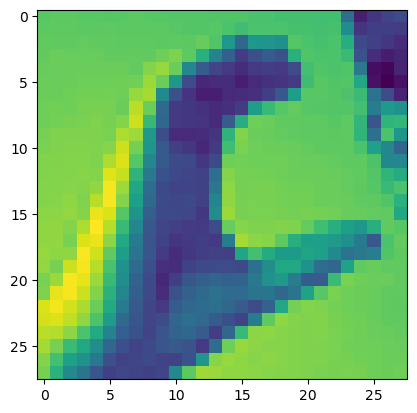

In [8]:

plt.imshow(X[2])

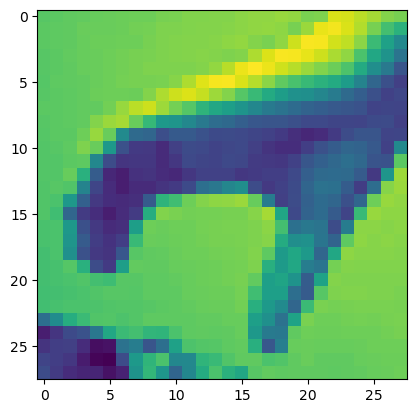

In [9]:
X_T = np.transpose(X, axes=(0, 2, 1))

plt.imshow(X_T[2])

But, we won't pass the X_T as an input to the LSTM, instead we will pass X as input and transform the dataset using only the Keras layers

In [10]:
print("Size of the un-transposed dataset: ", X.shape[0])
print("Size of the transposed dataset: ", X_T.shape[0])

Size of the un-transposed dataset:  27455
Size of the transposed dataset:  27455


In [11]:
y_encoded = to_categorical(y)
print("Shape of the target variable: ", y_encoded.shape)

print("First few records:")
print(y_encoded[:2])

Shape of the target variable:  (27455, 25)
First few records:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]


<AxesSubplot: ylabel='count'>

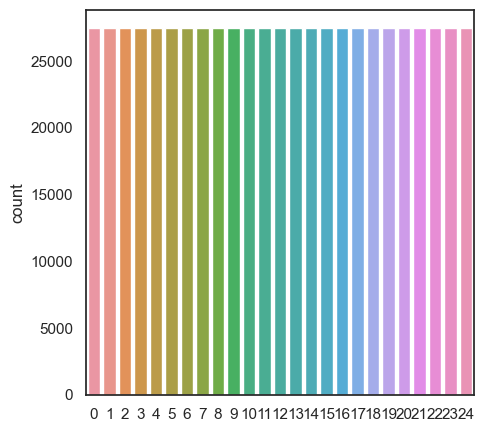

In [12]:
plt.figure(figsize = (5,5)) 
sns.set_theme(palette = 'pastel', style = 'white')
sns.countplot(y_encoded)

# Build & Train the Model

In [13]:
VALIDATION_SIZE = .2
EPOCHS = 5
BATCH_SIZE = 32
LATENT_DIM = 50

As mentioned above, we will create two models, one which will read the images horizontally and the second from top to bottom.

In [14]:
image_input = Input(shape=(IMG_SIZE, IMG_SIZE))

l2r_lstm = Bidirectional(LSTM(units=LATENT_DIM, return_sequences=True))(image_input)

l2r_lstm = GlobalMaxPool1D()(l2r_lstm)


In [15]:
#transpose_input = Lambda(lambda img: permute_dimensions(img, pattern=(0, 2, 1)))(image_input)
transpose_input = Lambda(lambda img: tf.transpose(img, perm=[0, 2, 1]))(image_input)

t2b_lstm = Bidirectional(LSTM(units=LATENT_DIM, return_sequences=True))(transpose_input)

t2b_lstm = GlobalMaxPool1D()(t2b_lstm)


In [16]:
l2r_t2b_lstm = Concatenate(axis=1)([l2r_lstm, t2b_lstm])

output_probs = Dense(NUM_CLASSES, activation='softmax')(l2r_t2b_lstm)

bi_lstm_model = Model(inputs=image_input, outputs=output_probs)

bi_lstm_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
bi_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 lambda (Lambda)                (None, 28, 28)       0           ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 28, 100)      31600       ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 28, 100)     31600       ['lambda[0][0]']                 
 )                                                                                            

In [18]:
history = bi_lstm_model.fit(
    X, y_encoded,
    validation_split=VALIDATION_SIZE, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)

Epoch 1/5
687/687 [==============================] - 38s 36ms/step - loss: 2.0349 - accuracy: 0.3839 - val_loss: 1.3168 - val_accuracy: 0.5902
Epoch 2/5
687/687 [==============================] - 22s 32ms/step - loss: 0.8856 - accuracy: 0.7291 - val_loss: 0.6536 - val_accuracy: 0.8122
Epoch 3/5
687/687 [==============================] - 23s 33ms/step - loss: 0.4789 - accuracy: 0.8662 - val_loss: 0.3517 - val_accuracy: 0.9071
Epoch 4/5
687/687 [==============================] - 22s 31ms/step - loss: 0.2805 - accuracy: 0.9271 - val_loss: 0.1906 - val_accuracy: 0.9570
Epoch 5/5
687/687 [==============================] - 22s 31ms/step - loss: 0.1839 - accuracy: 0.9536 - val_loss: 0.0989 - val_accuracy: 0.9878


In [19]:
print("Accuracy of the model is - " , bi_lstm_model.evaluate(X, y_encoded)[1]*100 , "%")

858/858 [==============================] - 10s 11ms/step - loss: 0.0951 - accuracy: 0.9886
Accuracy of the model is -  98.85631203651428 %


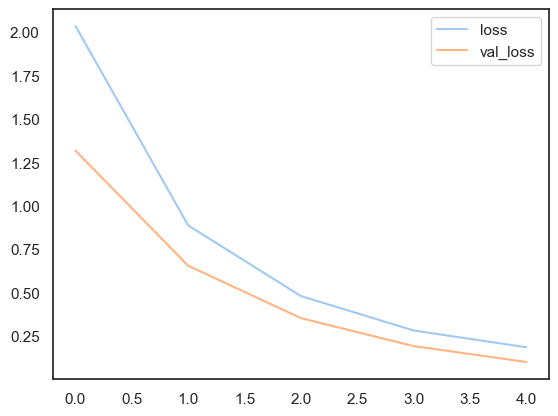

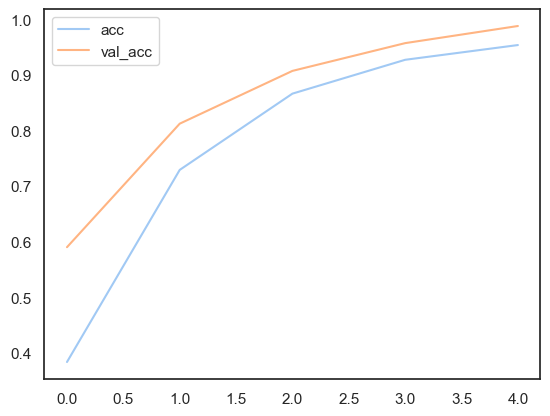

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# Make Predictions

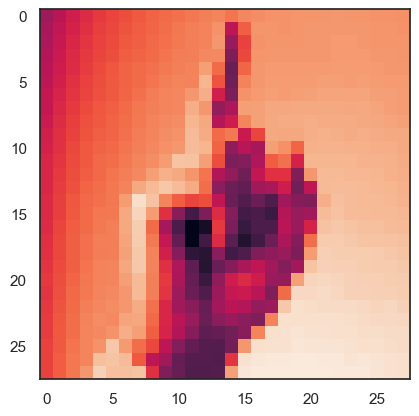

In [21]:
X_predict = pd.read_csv("sign_mnist_test.csv")
X_predict = train_df.values[:, 1:]/255.0 

X_predict = X_predict.reshape(-1, IMG_SIZE, IMG_SIZE)

plt.imshow(X_predict[0])

In [22]:
y_predicted_classes = np.argmax(bi_lstm_model.predict(X_predict), axis=1)

y_predicted_classes[0]

858/858 [==============================] - 12s 11ms/step


3

In [23]:
bi_lstm_model.save('bi_lstm_model.h5')

In [24]:
submissions = pd.DataFrame()
submissions["ImageId"] = [i for i in range(1, y_predicted_classes.shape[0]+1)]
submissions["Label"] = y_predicted_classes

submissions.to_csv("submissions.csv", index=False)